In [ ]:
# 0. Set up the environment

In [165]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
%cd '/content/drive/MyDrive/Colab Notebooks'
import zipfile
import os

zip_path = 'Concrete Crack Images for Classification.zip'
extract_to = '/content/crack_images1'

os.makedirs(extract_to, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Zip file extraction complete！")


/content/drive/MyDrive/Colab Notebooks
Zip file extraction complete！


In [168]:
!ls /content/crack_images1
!ls '/content/crack_images1/Concrete Crack Images for Classification'


'Concrete Crack Images for Classification'   __MACOSX
Negative  Positive


In [169]:
# 1. Set image parameters / 设置参数
image_size = 120  # Resize target size for images
base_path = '/content/crack_images1/Concrete Crack Images for Classification'
categories = ['Negative', 'Positive']
max_images_per_class = 20000  # Max images per class to load

In [170]:
# 2. Load and preprocess images with tone equalization and enhancement / 图像读取 + 色调均衡 + 灰度转换
def load_and_process_images(folder_path):
    data = []
    for label_index, label in enumerate(categories):
        class_folder = os.path.join(folder_path, label)
        count = 0
        for filename in os.listdir(class_folder):
            if count >= max_images_per_class:
                break
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)

            if img is not None:
                # Equalize / 色调均化
                yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
                yuv[..., 0] = cv2.equalizeHist(yuv[..., 0])
                eq_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)

                # Invert if image is too bright / 灰度转换
                if np.mean(gray_img) > 127:
                    gray_img = 255 - gray_img

                # Denoise with Gaussian blur / 高斯模糊
                gray_img = cv2.GaussianBlur(gray_img, (3, 3), 0)

                # Resize to uniform size / 尺寸调整
                resized = cv2.resize(gray_img, (image_size, image_size))

                # Append image and label / 保存图像与标签
                data.append([resized, label_index])
                count += 1

    return np.array(data, dtype=object)

    # Load dataset after function definition
    dataset = load_and_process_images(base_path)

In [171]:
# 3. Split features and labels + normalize / 分离特征和标签，并归一化
X, Y = [], []
for img, lbl in dataset:
    X.append(img)
    Y.append(lbl)
X = np.array(X).reshape(-1, image_size, image_size, 1) / 255.0
Y = np.array(Y)

In [172]:
# 4. Split into training and validation sets / 训练集/验证集划分
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

In [173]:
# 5. Define CNN model structure / CNN模型定义
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X_train.shape[1:]),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    BatchNormalization(),
    # Output layer for 2 classes
    Dense(2, activation='softmax')
])

# Compile model
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [174]:
# Data augmentation setup
aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1
)
aug.fit(X_train)

It helps us “make more training pictures.” For example, it turns, shifts, or zooms the original pictures a little to create new ones that look different but are still similar. This way, the model gets smarter and can recognize cracks even in pictures it hasn't seen before.

In [175]:
# 6. Train the model / 模型训练
history = model.fit(aug.flow(X_train, Y_train, batch_size=64),
                    epochs=15,
                    validation_data=(X_val, Y_val),
                    verbose=2)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 - 42s - 89ms/step - accuracy: 0.7857 - loss: 0.4517 - val_accuracy: 0.8849 - val_loss: 0.4575
Epoch 2/15
469/469 - 34s - 74ms/step - accuracy: 0.9039 - loss: 0.2547 - val_accuracy: 0.8858 - val_loss: 0.2945
Epoch 3/15
469/469 - 34s - 73ms/step - accuracy: 0.9401 - loss: 0.1689 - val_accuracy: 0.7512 - val_loss: 0.7765
Epoch 4/15
469/469 - 34s - 72ms/step - accuracy: 0.9529 - loss: 0.1379 - val_accuracy: 0.7681 - val_loss: 0.7270
Epoch 5/15
469/469 - 34s - 73ms/step - accuracy: 0.9585 - loss: 0.1195 - val_accuracy: 0.9344 - val_loss: 0.1758
Epoch 6/15
469/469 - 34s - 73ms/step - accuracy: 0.9638 - loss: 0.1058 - val_accuracy: 0.7115 - val_loss: 0.9714
Epoch 7/15
469/469 - 34s - 72ms/step - accuracy: 0.9686 - loss: 0.0945 - val_accuracy: 0.8853 - val_loss: 0.3401
Epoch 8/15
469/469 - 34s - 72ms/step - accuracy: 0.9696 - loss: 0.0897 - val_accuracy: 0.8379 - val_loss: 0.4659
Epoch 9/15
469/469 - 34s - 73ms/step - accuracy: 0.9739 - loss: 0.0775 - val_accuracy: 0.8381 - val_loss: 0

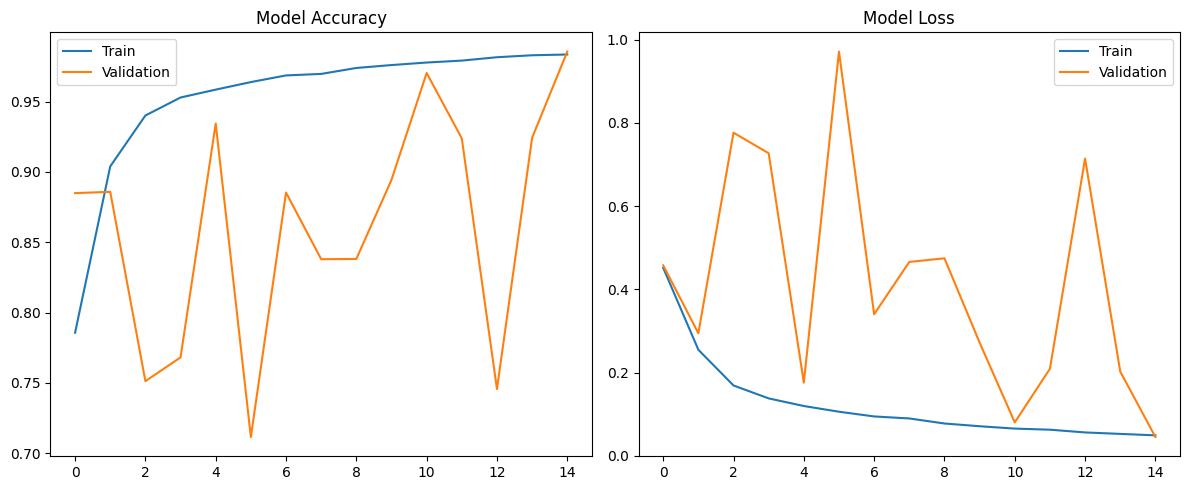

In [178]:
# 7. Plot training and validation accuracy/loss / 绘图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [179]:
# 8. Print classification report / 分类报告
val_preds = model.predict(X_val)
val_labels = np.argmax(val_preds, axis=1)
print(classification_report(Y_val, val_labels, target_names=categories))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.99      5021
    Positive       0.98      0.99      0.99      4979

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [180]:
import glob

# 9. Prediction function for single image
def test_accuracy_on_folder(folder_path):
    test_images = glob.glob(os.path.join(folder_path, "*"))  # Get list of all image files in folder
    total = len(test_images)

    # Output = 🚧 if you don't have a correct input
    if total == 0:
        print("Testing image not available / Test image不存在")
        return

    crack_count = 0
    no_crack_count = 0

    for path in test_images:
        img = cv2.imread(path)  # Load each image
        if img is None:
            continue

        # Same preprocessing as training: tone equalization, grayscale, inversion
        yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        yuv[..., 0] = cv2.equalizeHist(yuv[..., 0])
        eq_img = cv2.cvtColor(yuv, cv2.COLOR_YUV2BGR)
        gray_img = cv2.cvtColor(eq_img, cv2.COLOR_BGR2GRAY)

        if np.mean(gray_img) > 127:
            gray_img = 255 - gray_img

        # Resize and normalize
        gray_img = cv2.resize(gray_img, (image_size, image_size))
        gray_img = gray_img.reshape(1, image_size, image_size, 1) / 255.0

        # Make prediction
        prediction = model.predict(gray_img)[0]
        if prediction[1] > prediction[0]:
            crack_count += 1
        else:
            no_crack_count += 1

    print("\n=== Test Summary ===")
    print(f"Total: {total}")
    print(f"Crack: {crack_count}")
    print(f"No Crack: {no_crack_count}")
    print(f"Crack percentage: {crack_count / total:.2%}")
    print(f"No Crack percentage: {no_crack_count / total:.2%}")

# Run
test_accuracy_on_folder("/content/drive/MyDrive/Colab Notebooks/test_crack")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━